# Compte Rendu - Analyse 60 Millions de Consommateurs
**_Par Lionel Agboigba, Jules Besson-Legoff, Elie El Chartouni, Romain Scohy et Olympie Suquet_**


__Etudiants en M2 MIDO ID - Université Paris-Dauphine__

## Partie 1 : Analyse d’un classement de couches-culottes pour enfants

### Méthode 1 : PL

Ci dessous, le code source de la première partie

In [54]:
%matplotlib inline
import csv
import numpy as np
import pandas as pd
from optlang import Model, Variable, Constraint, Objective
import matplotlib.pyplot as plt

In [55]:
def readFileCSVData(file):
    """
    Lit un fichier CSV et retourne les pondérations, les données et les résultats du dossier 60Millions
    :param file:filename
    :return: ponderation : list
             data : list
             result : list
             types : A maximiser ou minimiser
    """
    ponderation = []
    data = []
    result = []  #derniere colonne
    types = []
    with open(file, newline='', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=';')
        for row in reader:
            if row[0] == 'ponderations':  #lecture des ponderations
                for i in range(1, len(row) - 1,2):
                    ponderation.append(float(row[i]))
                    types.append(str(row[i+1]))
            else:  #lecture des donnees et des resultats
                #donnees contient les notes et result la moyenne
                temp = []
                for i in range(1, len(row) - 1):
                    temp.append(row[i])
                #dicodata={row[0]:temp}
                #dicoresult={row[0]:float(row[len(row)-1])}
                data.append([row[0], temp])
                result.append([row[0], float(row[len(row) - 1])])

    return ponderation, data, result, types

In [56]:
def readFileCSVInterval(file):
    """
    Lit un fichier CSV et retourne les intervalles de YYYY
    :param file: filename
    :return: intervalle : dict
    """
    intervalle = {}
    with open(file, newline='', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=';')
        for row in reader:
            intervalle[row[0]] = [float(row[1]), float(row[2])]
    return intervalle

In [57]:
def createVars(nbelements,nbcriteres):
    """
    Retourne les 2 listes de variables correspondant aux notes / scores
    :param nbelements: nb d'items à comparer
           nbcriteres: nb de critères
    :return: U : liste des variables, correspondant aux notes / scores sur un critère pour un produit
             f : liste des variables, correspondant aux notes / scores sur un produit
    """
    U = []
    f = []
    for i in range(nbelements):
        x = Variable("f" + str(i + 1), lb=0)
        f.append(x)
        x = []
        for j in range(nbcriteres):
            x1 = Variable("U" + str(i + 1) + str(j + 1), lb=0)
            x.append(x1)
        U.append(x)

    return U,f

In [58]:
def constraints1to15(constraintList,ponderation,Uvars,f,nbelements,nbcriteres):
    """
    Retourne la liste des contraintes correspondant à l'écriture de la somme pondérée
    :param constraintList: liste des contraintes actuelles
           ponderation: liste des poids de chaque critère
           Uvars: notes d'un produit sur un critère spécifique
           f: note gloable du produit
           nbelements: nb d'items à comparer
           nbcriteres: nb de critères

    :return: C : liste des contraintes
    """
    C = constraintList
    for i in range(nbelements):
        calcul = 0
        for j in range(nbcriteres):
            calcul += ponderation[j] * Uvars[i][j]
        c = Constraint(calcul - f[i], ub=0, lb=0)
        C.append(c)
    return C

In [59]:
def createModel2(ponderation, data, result, intervalle, fixed):
    """
    fixed = True ===> fixer les variables f (question 2.1)
    fixed = False ===> ne pas fixer les variables f (question 2.2)
    """
    nbelements = len(data)
    nbcriteres = len(ponderation)
    #creation des variables
    U = []
    f = []
    U,f = createVars(nbelements,nbcriteres)

    #creation des contraintes (1) a (15)
    C = []
    C = constraints1to15(C,ponderation,U,f,nbelements,nbcriteres)

    #creation des contraintes (16) a (19)
    for i in range(len(result) - 1):
        if result[i][1] == result[i + 1][1]:
            c = Constraint(f[i] - f[i + 1], ub=0, lb=0)
            C.append(c)
        else:
            c = Constraint(f[i] - f[i + 1] - 0.1, lb=0)
            C.append(c)

    #creation des contraintes (20) a (29)
    for i in range(nbelements):
        for j in range(nbcriteres):
            c = Constraint(U[i][j], ub=intervalle.get(data[i][1][j])[1], lb=intervalle.get(data[i][1][j])[0])
            C.append(c)

    #Fixation des variables f
    if fixed:
        for i in range(nbelements):
            c = Constraint(f[i], lb=result[i][1], ub=result[i][1])
            C.append(c)

    model = Model(name='Modele')
    model.objective = Objective(f[0], direction='max')
    model.add(C)
    return model

In [60]:
def createModel3(ponderation, data, result, intervalle):
    nbelements = len(data)
    nbcriteres = len(ponderation)

    #creation des variables
    U = []
    f = []
    U,f = createVars(nbelements,nbcriteres)

    #creation des contraintes (1) a (15)
    C = []
    C = constraints1to15(C,ponderation,U,f,nbelements,nbcriteres)

    #creation des contraintes (16) a (19)
    for i in range(len(result) - 1):
        if i == 3 or i == 8:
            continue
        elif result[i][1] == result[i + 1][1]:
            c = Constraint(f[i] - f[i + 1], ub=0, lb=0)
            C.append(c)
        else:
            c = Constraint(f[i] - f[i + 1] - 0.1, lb=0)
            C.append(c)

    #creation des contraintes (20) a (29)
    for i in range(nbelements):
        for j in range(nbcriteres):
            if i == 1 and j == 2:
                c = Constraint(U[i][j], ub=intervalle.get(data[i][1][j])[1])
                C.append(c)
            else:
                c = Constraint(U[i][j], ub=intervalle.get(data[i][1][j])[1], lb=intervalle.get(data[i][1][j])[0])
                C.append(c)

    model = Model(name='Modele')
    model.objective = Objective(f[0], direction='max')
    model.add(C)
    return model

In [61]:
def createModel4(ponderation, data, result, intervalle):
    nbelements = len(data)
    nbcriteres = len(ponderation)
    #creation des variables
    U = []
    f = []
    U,f = createVars(nbelements,nbcriteres)

    #creation des contraintes (1) a (15)
    C = []
    C = constraints1to15(C,ponderation,U,f,nbelements,nbcriteres)

    #creation des contraintes (20) a (29)
    for i in range(nbelements):
        for j in range(nbcriteres):
            c = Constraint(U[i][j], ub=intervalle.get(data[i][1][j])[1], lb=intervalle.get(data[i][1][j])[0])
            C.append(c)

    obj = Objective(f[0], direction='max')
    model = Model(name='Modele')
    model.objective = obj
    model.add(C)
    return model

In [62]:
def CheckAdditiveModel(fileData, fileInt, question):
    ponderation, data, result,types = readFileCSVData(fileData)
    intervalle = readFileCSVInterval(fileInt)
    
    if question == "2.1":
        model = createModel2(ponderation, data, result, intervalle, False)
    elif question == "2.2":
        model = createModel2(ponderation, data, result, intervalle, True)
    elif question == "3":
        model = createModel3(ponderation, data, result, intervalle)
    elif question == "4":
        model = createModel4(ponderation, data, result, intervalle)
    else:
        print("Existe pas")
        return

    status = model.optimize()
    print("status:", model.status)
    print("objective value:", model.objective.value)
    print("----------")
    for var_name, var in model.variables.items():
        if var_name.startswith("f"):
            print(var_name, "=", var.primal)

**Question 1: CheckAdditiveModel**

In [63]:
print("Question 2.1")
CheckAdditiveModel('criteres.csv', 'intervalles.csv', "2.1")

Question 2.1
status: infeasible
objective value: 16.999999999999996
----------
f1 = 16.999999999999996
f2 = 12.999999999999998
f3 = 12.5
f4 = 12.5
f5 = 12.5
f6 = 12.5
f7 = 10.7
f8 = 10.7
f9 = 10.6
f10 = 10.6
f11 = 10.600000000000001
f12 = 6.0


**Question 2.2**

In [64]:
print("Question 2.2")
CheckAdditiveModel('criteres.csv', 'intervalles.csv', "2.2")

Question 2.2
status: infeasible
objective value: 17.0
----------
f1 = 17.0
f2 = 14.500000000000004
f3 = 12.500000000000005
f4 = 12.500000000000005
f5 = 12.500000000000005
f6 = 12.500000000000005
f7 = 11.300000000000004
f8 = 11.300000000000004
f9 = 9.500000000000004
f10 = 9.500000000000004
f11 = 9.500000000000004
f12 = 6.499999999999999


**Question 3**

In [65]:
print("Question 3")
CheckAdditiveModel('criteres.csv', 'intervalles.csv', "3")

Question 3
status: optimal
objective value: 20.0
----------
f1 = 20.0
f2 = 13.0
f3 = 12.8
f4 = 12.8
f5 = 11.799999999999999
f6 = 11.799999999999999
f7 = 10.7
f8 = 10.7
f9 = 10.6
f10 = 7.8
f11 = 7.8
f12 = 6.0


**Question 4**

In [66]:
print("Question 4")
CheckAdditiveModel('criteres.csv', 'intervalles.csv', "4")

Question 4
status: optimal
objective value: 20.0
----------
f1 = 20.0
f2 = 13.0
f3 = 12.8
f4 = 12.8
f5 = 10.0
f6 = 11.8
f7 = 10.6
f8 = 8.8
f9 = 10.6
f10 = 7.8
f11 = 7.8
f12 = 6.0


### Méthode 2 : ELECTRE TRI

**Code source de la 2e méthode**

In [67]:
def concordance_partiel(type, h, bi, j):
    """
    :param h: 1 Couche-culotte (donc liste)
    :param bi: profil (frontière qui YYYY)
    :param j: critère
    :return: 1 si H est au-moins aussi bon que bi sur le critère j, 0 sinon
    """
    if (type == 'max'):
        if h[j] >= bi[j]:
            return 1
        else:
            return 0
    elif (type == 'min'):
        if h[j] <= bi[j]:
            return 1
        else:
            return 0
    else:
        return -1

In [68]:
def concordanceGlobal(h, bi, poids, type):
    """
    :param type: vecteur contenant ['min'/'max'] pour chaque critere
    :param h: Couche culotte (liste)
    :param bi: profil (frontière qui YYYY)
    :param poids: vecteur contenant poids pour chaque critere
    :return: indice de concordance global, -1 si erreur
    """
    numerateur = 0.0
    denom = 0.0
    # Pour chaque critère j
    for j in range(1, len(h)):
        numerateur += poids[j - 1] * concordance_partiel(type[j - 1], h, bi, j)
        denom += poids[j - 1]
    return numerateur / denom

In [69]:
def Surclasse(seuilMajorite, h, bi, poids, type):
    """
    :param type: vecteur contenant ['min'/'max'] pour chaque critere
    :param seuilMajorite:
    :param h:
    :param bi:
    :param poids:
    :return:
    """
    if concordanceGlobal(h, bi, poids, type) >= seuilMajorite:
        return True
    else:
        return False

In [70]:
def AffectationOptimiste(h, classement, poids, type, seuil):
    """
    :param h:
    :param classement:
    :param poids:
    :param type:
    :param seuil:
    :return:
    """
    profil = len(classement) - 1  # OPTIMISATION : on peut commencer à len -2 car len-1 est forcement surclassé
    while (not (Surclasse(seuil, classement[profil], h, poids, type)) or (
        Surclasse(seuil, h, classement[profil], poids, type))):
        profil -= 1
    return profil 

In [71]:
def AffectationPessimiste(h, classement, poids, type, seuil):
    """
    :param h:
    :param classement:
    :param poids:
    :param type:
    :param seuil:
    :return:
    """
    profil = 0
    while not (Surclasse(seuil, h, classement[profil], poids, type)):
        profil += 1
    return profil

In [72]:
def EvalOptimiste(lesCouches, classement, poids, type, seuil):
    """
    :param lesCouches:
    :param classement:
    :param poids:
    :param type:
    :param seuil:
    :return:
    """
    liste = []
    dict = {}
    # pour chaque element de la matrice (une couche culotte), en partant de l'indice max (matrice profils[i][0]), on descend
    for couche in range(0, len(lesCouches)):
        dict[str(lesCouches[couche][0])] = categorie[
            AffectationOptimiste(lesCouches[couche], classement, poids, type, seuil)]
    return dict

In [73]:
def EvalPessimiste(lesCouches, classement, poids, type, seuil):
    """
    :param lesCouches:
    :param classement:
    :param poids:
    :param type:
    :param seuil:
    :return:
    """
    liste = []
    dict = {}
    for couche in range(0, len(lesCouches)):
        dict[str(lesCouches[couche][0])] = categorie[
            AffectationPessimiste(lesCouches[couche], classement, poids, type, seuil) - 1]  #return liste
    return dict


In [74]:
def createMatriceProfils(nomList,val,nbCriteres):
    """
    """
    matrice = []
    for idx, profil in enumerate(nomList):
        pro = [val[idx]]*nbCriteres
        a = [profil]
        a.extend(pro)
        matrice.append(a)
    return matrice

In [75]:
poids, mat, result,types = readFileCSVData('criteres.csv')
nbCriteres = len(poids)

In [76]:
# Transformation structure mat
flat_list = []
for sublist in mat:
    tempL=[]
    for item in sublist:
        if isinstance(item,list):
            for note in item:
                tempL.append(int(note))
        else:
            tempL.append(item)
    flat_list.append(tempL)
mat = flat_list

In [77]:
# Chargement des profils, categories
nomList = ['Profil 6 : Frontiere Le meilleur, impossible','Profil 5 : Dans les premiers','Profil 4 : Moyen +','Profil 3 : Moyen -','Profil 2 : Dans les derniers','Profil 1 : Frontiere Le pire,impossible']
valuesList = [100,3,2,1,-1,-2,-100]
matrice_profils = createMatriceProfils(nomList,valuesList,nbCriteres)
categorie = ['Très bon', 'Bon', 'Acceptable', 'Insuffisant', 'Inacceptable']

**Question 6** : Lambda = 0.55

In [78]:
op = EvalOptimiste(mat, matrice_profils, poids, types, 0.55)
pe = EvalPessimiste(mat, matrice_profils, poids, types, 0.55)
final_results = {key: [op[key], pe[key]] for key in op}
df_lambda1 = pd.DataFrame(final_results)
df_lambda1 = pd.DataFrame.from_records(final_results).T
df_lambda1.columns = ['Electre Optimiste', 'Electre Pessimiste']

In [79]:
print(df_lambda1)

,Electre Optimiste,Electre Pessimiste
Carref. Baby,Bon,Bon
Joone,Très bon,Très bon
Lillydoo,Acceptable,Acceptable
Lotus Baby,Bon,Bon
Love & Green,Bon,Bon
Lupilu,Bon,Bon
Mots d’enfants,Acceptable,Acceptable
Naty,Acceptable,Acceptable
Pamp. Activ.,Acceptable,Acceptable
Pamp. Baby,Acceptable,Acceptable


**Question 6** : Lambda = 0.75

In [80]:
op = EvalOptimiste(mat, matrice_profils, poids, types, 0.75)
pe = EvalPessimiste(mat, matrice_profils, poids, types, 0.75)
final_results = {key: [op[key], pe[key]] for key in op}
df_lambda2 = pd.DataFrame(final_results)
df_lambda2 = pd.DataFrame.from_records(final_results).T
df_lambda2.columns = ['Electre Optimiste', 'Electre Pessimiste']

In [81]:
print(df_lambda2)

,Electre Optimiste,Electre Pessimiste
Carref. Baby,Acceptable,Acceptable
Joone,Très bon,Très bon
Lillydoo,Insuffisant,Inacceptable
Lotus Baby,Acceptable,Inacceptable
Love & Green,Acceptable,Insuffisant
Lupilu,Acceptable,Insuffisant
Mots d’enfants,Insuffisant,Insuffisant
Naty,Bon,Acceptable
Pamp. Activ.,Acceptable,Acceptable
Pamp. Baby,Bon,Acceptable


**Question 7** : Résultats - Matrices de confusions

In [82]:
def plot_confusion_matrix(df_confusion, cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    plt.colorbar()
    tick_marks_x = np.arange(len(df_confusion.columns))
    tick_marks_y = np.arange(len(df_confusion.index))
    plt.xticks(tick_marks_x, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks_y, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

In [83]:
def getNote(val,inter,categorie,valuesList):
    for k,v in inter.items():
        if v[0] <= val <= v[1]:
            return categorie[valuesList.index(int(k))-1]
    print('Erreur GetNote')
    return 'sans cat'

def attributeGroup(items,inter,cat,valuesList):
    """ Converti les notes /20 en categories (Acceptable, Insuffisant...)
    """
    listNote = []
    for idx,k in enumerate(items):
        listNote.append([k[0],getNote(k[1],inter,cat,valuesList)]) # k[0] c'est le nom de la couche
    df_temp = pd.DataFrame(listNote)
    df_temp = pd.DataFrame.from_records(listNote)
    df_temp.columns = ['Couche', '60 Millions']
    df_temp.set_index('Couche',inplace=True)
    return df_temp

In [106]:
inter = readFileCSVInterval('intervalles.csv')
# serie60 contient le classement final concu par 60 Millions de Conso.
serie60 = attributeGroup(result,inter,categorie,valuesList)
print(serie60)

,60 Millions
Couche,
Etamine du Lys,Très bon
Air Wick,Bon
Biocoop,Bon
Nature et Découvertes,Acceptable
Daccide,Acceptable
Arkopharma,Acceptable
Ushuaïa,Insuffisant
LCA,Insuffisant
Ladrôme Laboratoire,Inacceptable


In [85]:
# On crée les 4 matrices de confusion
df_confusion_1_op = pd.crosstab(df_lambda1['Electre Optimiste'], serie60['60 Millions'])
df_confusion_1_pe = pd.crosstab(df_lambda1['Electre Pessimiste'], serie60['60 Millions'])
df_confusion_2_op = pd.crosstab(df_lambda2['Electre Optimiste'], serie60['60 Millions'])
df_confusion_2_pe = pd.crosstab(df_lambda2['Electre Pessimiste'], serie60['60 Millions'])

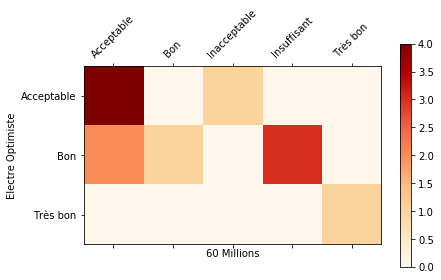

In [86]:
plot_confusion_matrix(df_confusion_1_op, cmap='OrRd')

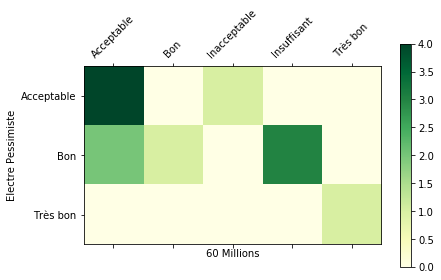

In [87]:
plot_confusion_matrix(df_confusion_1_pe, cmap='YlGn')

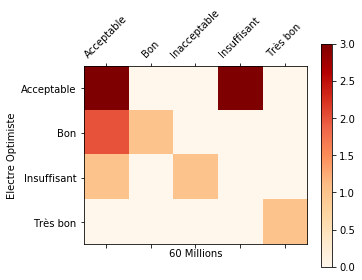

In [88]:
plot_confusion_matrix(df_confusion_2_op, cmap='OrRd')

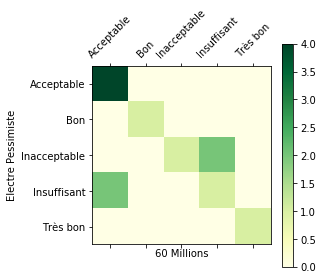

In [89]:
plot_confusion_matrix(df_confusion_2_pe, cmap='YlGn')

### Méthode 3 : Arbre de Décision

**Question 8**

In [90]:
class decisionnode:
    def __init__(self, col=-1, value=None, results=None, tb=None, fb=None):
        self.col = col  # column index of criteria being tested
        self.value = value  # vlaue necessary to get a true result
        self.results = results  # dict of results for a branch, None for everything except endpoints
        self.tb = tb  # true decision nodes
        self.fb = fb  # false decision nodes

# Divides a set on a specific column. Can handle numeric or nominal values

def divideset(rows, column, value):
    # Make a function that tells us if a row is in the first group
    # (true) or the second group (false)
    split_function = None
    # for numerical values
    if isinstance(value, int) or isinstance(value, float):
        split_function = lambda row: row[column] >= value
    # for nominal values
    else:
        split_function = lambda row: row[column] == value

    # Divide the rows into two sets and return them
    set1 = [row for row in rows if split_function(row)]  # if split_function(row)
    set2 = [row for row in rows if not split_function(row)]
    return (set1, set2)

# Create counts of possible results (last column of each row is the result)
def uniquecounts(rows):
    results = {}
    for row in rows:
        # The result is the last column
        r = row[len(row) - 1]
        if r not in results: results[r] = 0
        results[r] += 1
    return results

from collections import defaultdict

def uniquecounts_dd(rows):
    results = defaultdict(lambda: 0)
    for row in rows:
        r = row[len(row) - 1]
        results[r] += 1
    return dict(results)

# Entropy is the sum of p(x)log(p(x)) across all the different possible results
def entropy(rows):
    from math import log
    log2 = lambda x: log(x) / log(2)
    results = uniquecounts(rows)
    # Now calculate the entropy
    ent = 0.0
    for r in results.keys():
        # current probability of class
        p = float(results[r]) / len(rows)
        ent = ent - p * log2(p)
    return ent

def buildtree(rows, scorefun=entropy):
    if len(rows) == 0: return decisionnode()
    current_score = scorefun(rows)

    best_gain = 0.0
    best_criteria = None
    best_sets = None

    column_count = len(rows[0]) - 1  # last column is result
    for col in range(0, column_count):
        # find different values in this column
        column_values = set([row[col] for row in rows])

        # for each possible value, try to divide on that value
        for value in column_values:
            set1, set2 = divideset(rows, col, value)

            # Information gain
            p = float(len(set1)) / len(rows)
            gain = current_score - p * scorefun(set1) - (1 - p) * scorefun(set2)
            if gain > best_gain and len(set1) > 0 and len(set2) > 0:
                best_gain = gain
                best_criteria = (col, value)
                best_sets = (set1, set2)

    if best_gain > 0:
        trueBranch = buildtree(best_sets[0])
        falseBranch = buildtree(best_sets[1])
        return decisionnode(col=best_criteria[0], value=best_criteria[1],
                            tb=trueBranch, fb=falseBranch)
    else:
        return decisionnode(results=uniquecounts(rows))


def printtree(tree, indent=''):
    # Is this a leaf node?
    if tree.results != None:
        print(str(tree.results))
    else:
        # Print the criteria
        print('Column ' + str(tree.col) + ' : ' + str(tree.value) + '? ')
        
        # Print the branches
        print(indent + 'True->', printtree(tree.tb, indent + '  '))
        print(indent + 'False->',printtree(tree.fb, indent + '  '))

In [91]:
my_data = [
    [3, 3, 5],
    [2, 2, 4],
    [1, 3, 3],
    [1, 3, 3],
    [1, 1, 3],
    [2, 1, 3],
    [2, -1, 3],
    [1, -1, 3],
    [2, -1, 2],
    [2, -2, 2],
    [2, -2, 2],
    [1, -2, 1]
]

In [92]:
printtree(buildtree(my_data))

Column 1 : -1? 
Column 0 : 3? 
{5: 1}
  True-> None
Column 0 : 2? 
Column 1 : 2? 
{4: 1}
      True-> None
Column 1 : 1? 
{3: 1}
        True-> None
{3: 1, 2: 1}
        False-> None
      False-> None
    True-> None
{3: 4}
    False-> None
  False-> None
True-> None
Column 0 : 2? 
{2: 2}
  True-> None
{1: 1}
  False-> None
False-> None


## Partie 2 : Comparatif Aérosols

### 1e Méthode : PL

In [93]:
print("Question 2.1")
CheckAdditiveModel('criteresAEROSOL.csv', 'intervalles.csv', "2.1")
print("----------------------------------------")
print("Question 2.2")
CheckAdditiveModel('criteresAEROSOL.csv', 'intervalles.csv', "2.2")
print("----------------------------------------")
print("Question 3")
CheckAdditiveModel('criteresAEROSOL.csv', 'intervalles.csv', "3")
print("----------------------------------------")
print("Question 4")
CheckAdditiveModel('criteresAEROSOL.csv', 'intervalles.csv', "4")
print("----------------------------------------")

Question 2.1
status: optimal
objective value: 18.95
----------
f1 = 18.95
f2 = 12.899999999999999
f3 = 12.299999999999999
f4 = 10.9
f5 = 10.9
f6 = 10.0
f7 = 7.700000000000001
f8 = 7.6000000000000005
f9 = 5.4
f10 = 5.4
f11 = 5.4
f12 = 4.7
----------------------------------------
Question 2.2
status: optimal
objective value: 17.499999999999996
----------
f1 = 17.499999999999996
f2 = 15.000000000000005
f3 = 14.000000000000004
f4 = 12.000000000000004
f5 = 12.000000000000004
f6 = 11.0
f7 = 8.5
f8 = 7.999999999999999
f9 = 6.500000000000001
f10 = 6.500000000000001
f11 = 6.500000000000001
f12 = 6.0
----------------------------------------
Question 3
status: optimal
objective value: 18.950000000000003
----------
f1 = 18.950000000000003
f2 = 12.400000000000002
f3 = 12.3
f4 = 10.9
f5 = 10.1
f6 = 10.0
f7 = 7.699999999999999
f8 = 7.6
f9 = 3.4
f10 = 4.8
f11 = 4.8
f12 = 4.7
----------------------------------------
Question 4
status: optimal
objective value: 18.95
----------
f1 = 18.95
f2 = 12.9
f3 = 

### 2e Méthode : ELECTRE TRI

In [94]:
poids, mat, result,types = readFileCSVData('criteresAEROSOL.csv')
### Transforming structure
flat_list = []
for sublist in mat:
    tempL=[]
    for item in sublist:
        if isinstance(item,list):
            for note in item:
                tempL.append(int(note))
        else:
            tempL.append(item)
    flat_list.append(tempL)
mat = flat_list
##
# Creation matrice de profils
nomList = ['Profil 6 : Frontiere Le meilleur, impossible','Profil 5 : Dans les premiers','Profil 4 : Moyen +','Profil 3 : Moyen -','Profil 2 : Dans les derniers','Profil 1 : Frontiere Le pire,impossible']
valuesList = [100,3,2,1,-1,-2,-100]
nbCriteres = len(poids)
matrice_profils = createMatriceProfils(nomList,valuesList,nbCriteres)
categorie = ['Très bon', 'Bon', 'Acceptable', 'Insuffisant', 'Inacceptable']

In [95]:
## Seuil 55%
op = EvalOptimiste(mat, matrice_profils, poids, types, 0.55)
pe = EvalPessimiste(mat, matrice_profils, poids, types, 0.55)
final_results = {key: [op[key], pe[key]] for key in op}
df_l1 = pd.DataFrame(final_results)
df_l1 = pd.DataFrame.from_records(final_results).T
df_l1.columns = ['Electre Optimiste', 'Electre Pessimiste']
print(df_l1)

,Electre Optimiste,Electre Pessimiste
Air Wick,Bon,Bon
Arkopharma,Acceptable,Acceptable
Biocoop,Acceptable,Acceptable
Daccide,Acceptable,Acceptable
Etamine du Lys,Très bon,Très bon
LCA,Insuffisant,Insuffisant
Ladrôme Laboratoire,Inacceptable,Inacceptable
Le Comptoir Aroma,Inacceptable,Inacceptable
Nature et Découvertes,Acceptable,Acceptable
Pranarom,Inacceptable,Inacceptable


In [103]:
## Seuil 75%
op = EvalOptimiste(mat, matrice_profils, poids, types, 0.75)
pe = EvalPessimiste(mat, matrice_profils, poids, types, 0.75)
final_results = {key: [op[key], pe[key]] for key in op}
df_l2 = pd.DataFrame(final_results)
df_l2 = pd.DataFrame.from_records(final_results).T
df_l2.columns = ['Electre Optimiste', 'Electre Pessimiste']

,Electre Optimiste,Electre Pessimiste
Air Wick,Acceptable,Acceptable
Arkopharma,Acceptable,Acceptable
Biocoop,Acceptable,Acceptable
Daccide,Insuffisant,Insuffisant
Etamine du Lys,Bon,Bon
LCA,Insuffisant,Insuffisant
Ladrôme Laboratoire,Inacceptable,Inacceptable
Le Comptoir Aroma,Inacceptable,Inacceptable
Nature et Découvertes,Acceptable,Acceptable
Pranarom,Inacceptable,Inacceptable


In [105]:
print(df_l2)

                      Electre Optimiste Electre Pessimiste
Air Wick                     Acceptable         Acceptable
Arkopharma                   Acceptable         Acceptable
Biocoop                      Acceptable         Acceptable
Daccide                     Insuffisant        Insuffisant
Etamine du Lys                      Bon                Bon
LCA                         Insuffisant        Insuffisant
Ladrôme Laboratoire        Inacceptable       Inacceptable
Le Comptoir Aroma          Inacceptable       Inacceptable
Nature et Découvertes        Acceptable         Acceptable
Pranarom                   Inacceptable       Inacceptable
Puressentiel               Inacceptable       Inacceptable
Ushuaïa                     Insuffisant       Inacceptable


In [97]:
# Matrices de confusion
inter = readFileCSVInterval('intervalles.csv')
# serieAERO contient le classement final concu par 60 Millions de Conso.
serieAERO = attributeGroup(result,inter,categorie,valuesList)
print(serieAERO)

# On crée les 4 matrices de confusion
df_confusion_1_op = pd.crosstab(df_l1['Electre Optimiste'], serieAERO['60 Millions'])
df_confusion_1_pe = pd.crosstab(df_l1['Electre Pessimiste'], serieAERO['60 Millions'])
df_confusion_2_op = pd.crosstab(df_l2['Electre Optimiste'], serieAERO['60 Millions'])
df_confusion_2_pe = pd.crosstab(df_l2['Electre Pessimiste'], serieAERO['60 Millions'])

                        60 Millions
Couche                             
Etamine du Lys             Très bon
Air Wick                        Bon
Biocoop                         Bon
Nature et Découvertes    Acceptable
Daccide                  Acceptable
Arkopharma               Acceptable
Ushuaïa                 Insuffisant
LCA                     Insuffisant
Ladrôme Laboratoire    Inacceptable
Pranarom               Inacceptable
Le Comptoir Aroma      Inacceptable
Puressentiel           Inacceptable


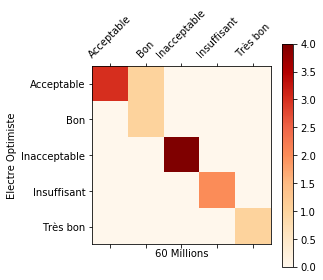

In [98]:
plot_confusion_matrix(df_confusion_1_op, cmap='OrRd')

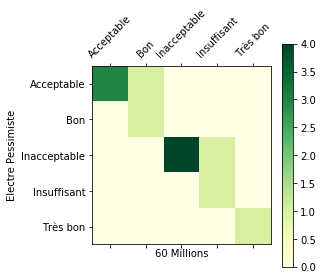

In [99]:
plot_confusion_matrix(df_confusion_1_pe, cmap='YlGn')

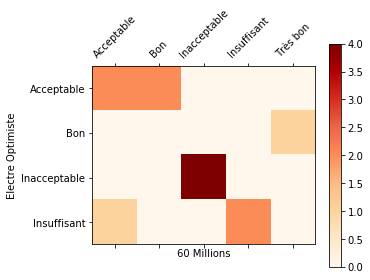

In [100]:
plot_confusion_matrix(df_confusion_2_op, cmap='OrRd')

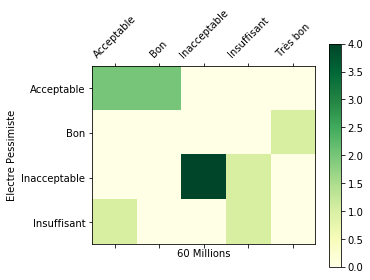

In [101]:
plot_confusion_matrix(df_confusion_2_pe, cmap='YlGn')

Conclusion : Avec méthode optimiste avec lambda à 0.55, on se rapproche des résultats du magazine ; avec une véritable approche mathématique

### 3e Méthode : Arbre de décision

In [102]:
# code

## Conclusion

**60 Millions de Consommateurs** fourni des comparatifs qui ne veulent rien dire mathématiquement parlant ; car on n'arrive pas à retrouver les coefficients / notes utilisés dans leurs comparatifs.
Il parait plus intelligent de mettre en place une méthode et de l'expliquer : cette méthode peut être les coefficents, ELECTRE TRI, ou une un arbre de décision.  

Mais le plus important : **c'est de choisir une méthode et de _la rendre publique_**, et pas essayer de la cacher